# Goal
This notebook summarizes all road fatality data at city level and country level

In [6]:
schema ={
    "source":"Data source",
    "level":"city, state or country",
    "country":"Country",
    "state":"State",
    "city":"City",
    "date_created":"Date the data was created for",
    "num_person_killed":"number of person killed",
     "num_person_killed_share":"number of person killed share",
    "num_person_killed_per_lakh":"number of person killed per lakh(100_000)",
    "num_accidents":"number of accidents",
    "num_accidents_per_lakh":"number of accidents per lakh(100_000)",
}


# 0. Clean Data at country level

In [13]:
import gspread
def load_all():
    serviceaccount = "/Users/yuan/Dropbox (Personal)/personal files/ssh/google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    city_meta["city_lower"] = city_meta["City"].apply(lambda x: x.lower().replace(" ", ""))
    return city_meta

city_meta = load_all()
# get a list of country
countryls = city_meta['country_clean'].unique()
print(countryls)

['Argentina' 'Australia' 'Austria' 'Bangladesh' 'Belgium' 'Bolivia'
 'Botswana' 'Brazil' 'Canada' 'Chile' 'China' 'Colombia' 'Denmark'
 'Ecuador' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Hungary'
 'India' 'Indonesia' 'Israel' 'Italy' 'Japan' 'Kenya' 'Lithuania'
 'Malaysia' 'Mexico' 'Netherlands' 'New Zealand' 'Nigeria' 'Peru'
 'Philippines' 'Poland' 'Republic of Korea' 'Russian Federation' 'Rwanda'
 'Serbia' 'Singapore' 'South Africa' 'Spain' 'Sweden' 'Thailand' 'Turkey'
 'Uganda' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States of America']


In [25]:
import pandas as pd
import numpy as np
import os

ROOTFOLDER = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data"
RAWFOLDER = f"{ROOTFOLDER}/_raw/_road_fatality/_fatality"
TRANSFORM_FOLDER = f"{ROOTFOLDER}/_transformed/t_road_fatality/level=country"
if not os.path.exists(TRANSFORM_FOLDER):
    os.makedirs(TRANSFORM_FOLDER)

name_map = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Netherlands (Kingdom of the)": "Netherlands",
    "Turkiye": "Turkey",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
}

In [47]:
df_other = pd.read_csv(os.path.join(RAWFOLDER, "who_road_fatality.csv"), header = [0,1])
df_other.columns = [str("_".join(x)) for x in df_other.columns]
df_other.rename(columns = {
    "Unnamed: 0_level_0_Countries, territories and areas":"country",
    "Unnamed: 1_level_0_Year":"year",
    "Estimated number of road traffic deaths_Both sexes":"num_person_killed",
    "Estimated road traffic death rate (per 100 000 population)_Both sexes":"num_person_killed_per_lakh",
}, inplace = True)
df_other = df_other[['country','year','num_person_killed','num_person_killed_per_lakh']]
df_other['country'] = df_other['country'].apply(lambda x: name_map.get(x, x) if x in name_map else x)
df_other['num_person_killed'] = df_other['num_person_killed'].apply(lambda x: float(x.split(" [")[0]))
df_other['num_person_killed_per_lakh'] = df_other['num_person_killed_per_lakh'].apply(lambda x: float(x.split(" [")[0]))
df_other['num_person_killed_per_lakh'].describe()

ninter = len(set(countryls).intersection(set(df_other['country'].unique())))
print(f"Number of intersection countries: {ninter}")
print(f"Number of countries in city_meta: {len(countryls)}")
# check which country is not in the intersection
assert set(countryls) - set(df_other['country'].unique())==set(), "Some countries are not in the intersection"

Number of intersection countries: 50
Number of countries in city_meta: 50


In [48]:
df_other['level'] = "country"
df_other = df_other[df_other['country'].isin(countryls)]
df_other\
    .to_csv(os.path.join(TRANSFORM_FOLDER, "t_road_fatality.csv"), index = False)

# 1. Search for individual city level person killed per lakh via GPT

In [49]:
# load the gpt result
import json
import pandas as pd
import os
gpt_path = "road_fatality_gpt.json"
with open(gpt_path, "r") as f:
    gpt = json.load(f)
df_gpt = pd.DataFrame(gpt)
df_gpt['level'] = "city"
df_gpt.rename(columns = {'year of data':'year',
                         'state or province':'state',
                         'number of person killed per 100k':'num_person_killed_per_lakh'}, inplace = True)
df_gpt

,city,country,state,year,num_person_killed_per_lakh,level
0,Buenos Aires,Argentina,Buenos Aires,2019,13.5,city
1,Sydney,Australia,New South Wales,2019,4.7,city
2,Vienna,Austria,Vienna,2019,2.5,city
3,Saidpur,Bangladesh,Rangpur,2019,12.0,city
4,Rajshahi,Bangladesh,Rajshahi,2019,12.0,city
...,...,...,...,...,...,...
122,New York,United States,New York,2019,4.4,city
123,Los Angeles,United States,California,2019,8.2,city
124,Houston,United States,Texas,2019,12.8,city
125,Philadelphia,United States,Pennsylvania,2019,9.6,city


In [51]:
# check whether all country names match betwen the two datasets
ninter = len(set(df_gpt['country'].unique()).intersection(set(df_other['country'].unique())))
print(f"Number of intersection countries: {ninter}")
missing_country = set(df_gpt['country'].unique()) - set(df_other['country'].unique())
missing_country_r = set(df_other['country'].unique()) - set(df_gpt['country'].unique())
print(f"Missing countries: {missing_country}")
print(f"Missing countries in the other dataset: {missing_country_r}")
gpt_country_map = {
    "United States": "United States of America",
    "South Korea": "Republic of Korea",
    "Russia": "Russian Federation",
    "Taiwan": "China",
}
df_gpt['country'] = df_gpt['country'].apply(lambda x: gpt_country_map.get(x, x) if x in gpt_country_map else x)
# confirm that all country names match
ninter = len(set(df_gpt['country'].unique()).intersection(set(df_other['country'].unique())))
print(f"Number of intersection countries: {ninter}")

Number of intersection countries: 47
Missing countries: {'Russia', 'Taiwan', 'United States', 'South Korea'}
Missing countries in the other dataset: {'United States of America', 'Russian Federation', 'Republic of Korea'}
Number of intersection countries: 50


In [55]:
# merge the gpt result with country level and compare the difference on the number of person killed
df_other_19 = df_other[df_other['year']==2019].reset_index(drop = True)
df_merge = df_gpt[['city', 'country', 'state', 'year', 'num_person_killed_per_lakh']]\
    .merge(df_other_19[['country', 'num_person_killed_per_lakh']], 
                        on = ['country'],
                        how = 'left', 
                        suffixes = ('_city', '_country_who'))
df_merge

,city,country,state,year,num_person_killed_per_lakh_city,num_person_killed_per_lakh_country_who
0,Buenos Aires,Argentina,Buenos Aires,2019,13.5,14.1
1,Sydney,Australia,New South Wales,2019,4.7,4.9
2,Vienna,Austria,Vienna,2019,2.5,4.9
3,Saidpur,Bangladesh,Rangpur,2019,12.0,15.3
4,Rajshahi,Bangladesh,Rajshahi,2019,12.0,15.3
...,...,...,...,...,...,...
122,New York,United States of America,New York,2019,4.4,12.7
123,Los Angeles,United States of America,California,2019,8.2,12.7
124,Houston,United States of America,Texas,2019,12.8,12.7
125,Philadelphia,United States of America,Pennsylvania,2019,9.6,12.7


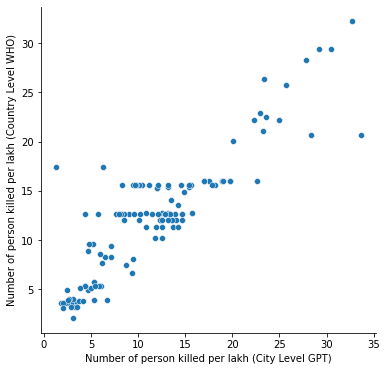

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data = df_merge, 
                x = 'num_person_killed_per_lakh_city', 
                y = 'num_person_killed_per_lakh_country_who', ax = ax)
ax.set_xlabel("Number of person killed per lakh (City Level GPT)")
ax.set_ylabel("Number of person killed per lakh (Country Level WHO)")
sns.despine()

# 2. Clean the Available Data city by city from their own country data

In [ ]:
# load current availiable country level data first
